In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from lib.dataset_utils import *
from lib.mnist_model import *
from lib.adv_model import *
from lib.dknn_attack_v2 import DKNNAttackV2
from lib.dknn import DKNNL2
from lib.utils import *

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
# Set all random seeds
seed = 2020
np.random.seed(seed)
torch.manual_seed(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
(x_train, y_train), (x_valid, y_valid), (x_test, y_test) = load_mnist_all(
    '/data', val_size=0.1, shuffle=True, seed=seed)

Create model. Here is `mnist_at.h5`.

In [6]:
model_name = 'mnist_at.h5'
basic_net = BasicModel()
config = {'epsilon': 0.3,
          'num_steps': 40,
          'step_size': 0.01,
          'random_start': True,
          'loss_func': 'xent'}
net = PGDL2Model(basic_net, config)

Load model weight

In [8]:
# Set up model directory
save_dir = os.path.join(os.getcwd(), 'saved_models/mnist/')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)

net = net.to(device)
net.load_state_dict(torch.load(model_path))
net = net.basic_net
net.eval()

BasicModel(
  (conv1): Conv2d(1, 64, kernel_size=(8, 8), stride=(2, 2), padding=(3, 3))
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(64, 128, kernel_size=(6, 6), stride=(2, 2), padding=(3, 3))
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (relu3): ReLU(inplace=True)
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)

Build DkNN

In [9]:
layers = ['relu1', 'relu2', 'relu3', 'fc']

dknn = DKNNL2(net, x_train, y_train, x_valid, y_valid, layers, 
              k=75, cosine=True, num_classes=10)

Build kNN on neural network representation

In [ ]:
layers = ['relu3']

dknn = DKNNL2(net, x_train, y_train, x_valid, y_valid, layers, 
              k=15, cosine=False, num_classes=10)

This is how to build an ordinary kNN without neural network components

In [24]:
net_knn = KNNModel()
layers = ['identity']
dknn = DKNNL2(net_knn, x_train, y_train, x_test, y_test, 
              layers, k=5, num_classes=10)

Check clean accuracy

In [25]:
with torch.no_grad():
    y_pred = dknn.classify(x_test)
    ind = np.where(y_pred.argmax(1) == y_test.numpy())[0]
    print((y_pred.argmax(1) == y_test.numpy()).sum() / y_test.size(0))

0.9671


Helper functions we use in the evaluation section. Set attack parameters in `attack_batch`.

In [35]:
def attack_batch(attack, x, y, init_mode, init_mode_k, batch_size):
    x_adv = torch.zeros_like(x)
    total_num = x.size(0)
    num_batches = int(np.ceil(total_num / batch_size))
    for i in range(num_batches):
        begin = i * batch_size
        end = (i + 1) * batch_size
        x_adv[begin:end] = attack(
            x[begin:end], y[begin:end], 2, guide_layer=layers, m=6,
            init_mode=init_mode, init_mode_k=init_mode_k,
            binary_search_steps=10, max_iterations=1000, learning_rate=1e-1,
            initial_const=1e0, max_linf=None, random_start=True,
            thres_steps=200, check_adv_steps=200, verbose=False)
    return x_adv

num = 2

def full_eval(dknn):
    with torch.no_grad():
        y_pred = dknn.classify(x_test)
        ind = np.where(y_pred.argmax(1) == y_test.numpy())[0]
    print((y_pred.argmax(1) == y_test.numpy()).sum() / y_test.size(0))
    
    dist_all = np.zeros(num) + 1e9
    x_adv_all = x_test[ind][:num].clone()
    attack = DKNNAttackV2(dknn)
    
    x_adv = attack_batch(
        attack, x_test[ind][:num].cuda(), y_test[ind][:num], 1, 1, 100)
    with torch.no_grad():
        y_pred = dknn.classify(x_adv)
        ind_adv = y_pred.argmax(1) != y_test[ind][:num].numpy()
        dist = (x_adv.cpu() - x_test[ind][:num]).view(
            num, -1).norm(2, 1).numpy()
    for i in range(num):
        if ind_adv[i] and (dist[i] < dist_all[i]):
            dist_all[i] = dist[i]
            x_adv_all[i] = x_adv[i]
            
    for k in range(1, 3):
        x_adv = attack_batch(
            attack, x_test[ind][:num].cuda(), y_test[ind][:num], 2, k, 100)
        with torch.no_grad():
            y_pred = dknn.classify(x_adv)
            ind_adv = y_pred.argmax(1) != y_test[ind][:num].numpy()
            dist = (x_adv.cpu() - x_test[ind][:num]).view(
                num, -1).norm(2, 1).numpy()
        for i in range(num):
            if ind_adv[i] and (dist[i] < dist_all[i]):
                dist_all[i] = dist[i]
                x_adv_all[i] = x_adv[i]
                
    adv_acc = (dist_all == 1e9).mean()
    print('adv accuracy: %.4f, mean dist: %.4f' % (
        adv_acc, dist_all[dist_all < 1e9].mean()))
    return dist_all, x_adv_all

Running the attack with full evaluation

In [36]:
start = time.time()
dist, x_adv = full_eval(dknn)
print('Total time %.4fs' % (time.time() - start))

0.9671
adv accuracy: 0.0000, mean dist: 2.6631
Total time 73.4050s


In [37]:
dist.mean()

2.663069009780884

Showing some examples

clean


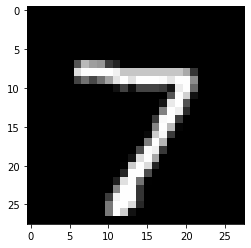

adv


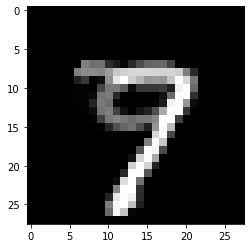

In [40]:
i = 0
print('clean')
plt.imshow(x_test[i].detach().reshape(28, 28), cmap='gray')
plt.show()
print('adv')
plt.imshow(x_adv[i].detach().reshape(28, 28), cmap='gray')
plt.show()